# Naive method theoretical analysis
This notebook aims to numerically compare two lower bounds (DKW bound and Markov bound) of the coverage rate by the naive method.

In [40]:
%load_ext autoreload
%autoreload 2

import numpy as np
from math import sqrt,log, exp
from scipy.stats import beta

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'


In [234]:
def DKW_bound(T,n,a):
    """
    Parameters
    ----------
    T: int
        Number of models
    n: int
        Calibration size
    a: float
        Confidence level
    """
    # Calculate the error term
    err = sqrt(log(2*T)/2) + sqrt(2)*T*exp(-log(2*T))/(sqrt(log(2*T))+sqrt(log(2*T)+4/math.pi))
    bound = (1+1/n)*(1-a) - err/sqrt(n)
    return bound

def Markov_bound(T,n,a,b=100):
    l = int(a*(n+1))
    return (1-1/b)*beta.ppf(1/(T*b), n+1-l,l)

def inv_DKW(T,n,a):
    """
    calculate the corrected confidence level when theoretical coverage rate is 1-a
    """
    err = sqrt(log(2*T)/2) + sqrt(2)*T*exp(-log(2*T))/(sqrt(log(2*T))+sqrt(log(2*T)+4/math.pi))
    err /= sqrt(n)
    ac = 1-(1-a+err)/(1+1/n)
    return ac if ac>0 else 0

def inv_Markov(T,n,a,b=100):
    aseq = np.arange(0.001,1,0.01)
    lseq = np.array([int(a*(n+1)) for a in aseq])
    bound = (1-1/b)*beta.ppf(1/(T*b), n+1-lseq,lseq)
    idx = np.argmin(abs(bound-(1-a)))
    return 0 if max(bound)<(1-a) else aseq[idx]

##  How bounds vary w.r.t model size T and calibration size n

In [142]:
# Change the model size T
Tseq = np.arange(2,1000,1)
a, n = 0.1, 100
Dbound_T = list(map(DKW_bound, Tseq, [n]*len(Tseq), [a]*len(Tseq)))
Mbound_T = list(map(Markov_bound, Tseq, [n]*len(Tseq), [a]*len(Tseq)))

# Change the calibration size n
nseq = np.arange(100,5000,10)
a, T = 0.1, 100
Dbound_n = list(map(DKW_bound, [T]*len(nseq), nseq, [a]*len(nseq)))
Mbound_n = list(map(Markov_bound, [T]*len(nseq), nseq, [a]*len(nseq)))

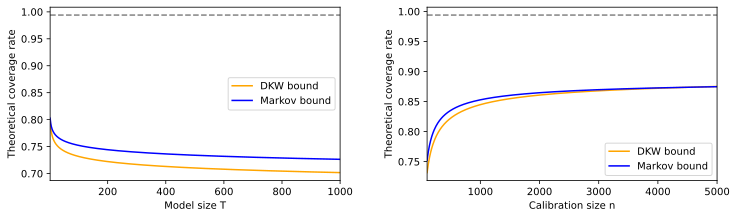

In [252]:
# Plot the bound
fig, axs = plt.subplots(1,2, figsize=(10,3))
fig.tight_layout()
plt.subplots_adjust(wspace=0.3)

axs[0].plot(Tseq, Dbound_T, label="DKW bound", linestyle="-", color="orange")
axs[0].plot(Tseq, Mbound_T, label="Markov bound", linestyle="-", color="blue")
axs[0].axhline(y=1-a, color='gray', linestyle='--')
axs[0].set_xlabel("Model size T")
axs[0].set_ylabel("Theoretical coverage rate")
axs[0].set_xlim([2,1000])
axs[0].legend()

axs[1].plot(nseq, Dbound_n, label="DKW bound", linestyle="-", color="orange")
axs[1].plot(nseq, Mbound_n, label="Markov bound", linestyle="-", color="blue")
axs[1].axhline(y=1-a, color='gray', linestyle='--')
axs[1].set_xlabel("Calibration size n")
axs[1].set_ylabel("Theoretical coverage rate")
axs[1].set_xlim([100,5000])
axs[1].legend(loc ="lower right")
plt.show()


##  How bounds vary w.r.t confidence level

In [163]:
# Change the confidence level alpha
aseq = np.arange(0.001,1,0.01)
T, n = 100, 100
Dbound_a = list(map(DKW_bound, [T]*len(aseq), [n]*len(aseq), aseq))
Mbound_a = list(map(Markov_bound, [T]*len(aseq), [n]*len(aseq), aseq))

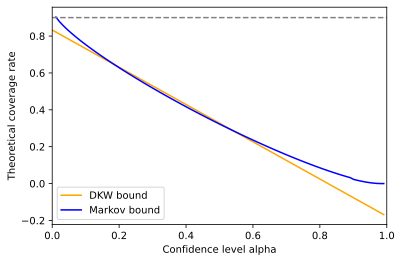

In [164]:
plt.plot(aseq, Dbound_a, label="DKW bound", linestyle="-", color="orange")
plt.plot(aseq, Mbound_a, label="Markov bound", linestyle="-", color="blue")
plt.axhline(y=1-a, color='gray', linestyle='--')
plt.xlabel("Confidence level alpha")
plt.ylabel("Theoretical coverage rate")
plt.xlim([0,1])
plt.legend()

# Confidence level correction
This subsection studies how the confidence level should be adjusted in order to achieve desired coverage rate.

In [245]:
aseq=np.arange(0.01,0.2,0.01)
T,n = 100,1000

ac_DKW=list(map(inv_DKW, [T]*len(aseq), [n]*len(aseq), aseq))
ac_Markov=list(map(inv_Markov, [T]*len(aseq), [n]*len(aseq), aseq))

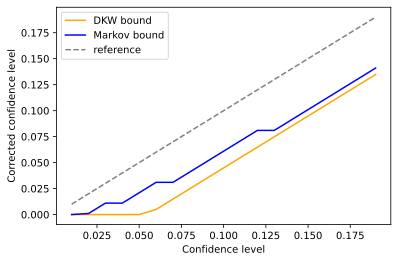

In [246]:
plt.plot(aseq, ac_DKW, label="DKW bound", linestyle="-", color="orange")
plt.plot(aseq, ac_Markov, label="Markov bound", linestyle="-", color="blue")
plt.plot(aseq, aseq, label="reference", linestyle="--", color="grey")

plt.xlabel("Confidence level")
plt.ylabel("Corrected confidence level")
plt.legend()